In [18]:
from SNN import DeepSpectralNet, StableHybridDSN
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=0
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

assert X_test.shape[1]==X_train.shape[1]


In [3]:
mlp = MLPRegressor(
        hidden_layer_sizes=(128, 128),
        activation="relu",
        solver="adam",
        alpha=1e-4,
        batch_size=256,
        learning_rate_init=1e-3,
        max_iter=100,
        random_state=0
    )

In [162]:
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

/Users/isaac/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [163]:
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)
r2 = r2_score(y_test, y_pred)
print("R²:", r2)

MSE: 0.2682204029660233
R²: 0.7943023930583188


In [ ]:
d_input = X_train.shape[1]
epochs = 50
learning_rate = 1e-3
n_samples = X.shape[0]
batch_size = 128

dsn = DeepSpectralNet(
    input_dim=d_input,
    hidden_dim=2,  
    output_dim=1,
    depth=1   
)

# ==== Optimiseur et loss ====
optimizer = torch.optim.AdamW(dsn.parameters(), lr=learning_rate, weight_decay=1e-4)
criterion = nn.MSELoss()

In [49]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)

# Avant le training
y_mean = y_train.mean()
y_std = y_train.std()
y_train_scaled = (y_train - y_mean) / y_std
y_test_scaled = (y_test - y_mean) / y_std

y_train_t = torch.tensor(y_train_scaled.to_numpy(), dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test_scaled.to_numpy(), dtype=torch.float32).unsqueeze(1)

print(X_train_t.shape)  # (N_train, d_input)
print(y_train_t.shape)  # (N_train, 1)

batch_size = 256

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

torch.Size([16512, 8])
torch.Size([16512, 1])


In [50]:
epochs = 300
train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    # ======== Training ========
    dsn.train()
    total_train_loss = 0.0

    for Xb, yb in train_loader:
        optimizer.zero_grad()
        y_pred = dsn(Xb)         
        loss = criterion(y_pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(dsn.parameters(), max_norm=1.0)
        optimizer.step()

        total_train_loss += loss.item() * Xb.size(0)

    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_loss_history.append(avg_train_loss)
    scheduler.step(avg_train_loss)

    # ======== Validation ========
    dsn.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for Xb, yb in test_loader:  
            y_pred = dsn(Xb)
            loss = criterion(y_pred, yb)
            total_val_loss += loss.item() * Xb.size(0)

    avg_val_loss = total_val_loss / len(test_loader.dataset)
    val_loss_history.append(avg_val_loss)

    # ======== Logging ========
    if epoch % 20 == 0 or epoch == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.6f} | "
              f"Val Loss: {avg_val_loss:.6f} | LR: {current_lr:.6f}")

Epoch 1/300 | Train Loss: 0.866939 | Val Loss: 0.727098 | LR: 0.001000
Epoch 21/300 | Train Loss: 0.298793 | Val Loss: 0.290381 | LR: 0.001000
Epoch 41/300 | Train Loss: 0.255044 | Val Loss: 0.255413 | LR: 0.001000
Epoch 61/300 | Train Loss: 0.244228 | Val Loss: 0.246565 | LR: 0.001000
Epoch 81/300 | Train Loss: 0.239722 | Val Loss: 0.247162 | LR: 0.001000
Epoch 101/300 | Train Loss: 0.232465 | Val Loss: 0.244961 | LR: 0.001000
Epoch 121/300 | Train Loss: 0.229924 | Val Loss: 0.240091 | LR: 0.001000
Epoch 141/300 | Train Loss: 0.222709 | Val Loss: 0.229185 | LR: 0.001000
Epoch 161/300 | Train Loss: 0.220896 | Val Loss: 0.232092 | LR: 0.001000
Epoch 181/300 | Train Loss: 0.218377 | Val Loss: 0.230590 | LR: 0.001000
Epoch 201/300 | Train Loss: 0.215617 | Val Loss: 0.222048 | LR: 0.000500
Epoch 221/300 | Train Loss: 0.213194 | Val Loss: 0.222767 | LR: 0.000250
Epoch 241/300 | Train Loss: 0.213028 | Val Loss: 0.220999 | LR: 0.000250
Epoch 261/300 | Train Loss: 0.211720 | Val Loss: 0.219571

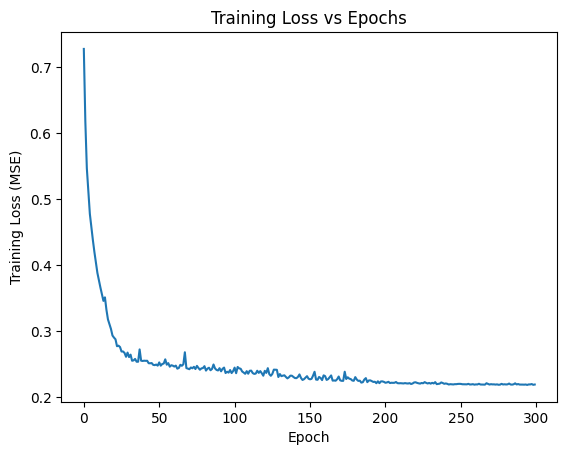

In [51]:
plt.figure()
plt.plot(val_loss_history)
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Training Loss vs Epochs")
plt.show()

In [52]:
dsn.eval()
with torch.no_grad():
    y_pred_scaled = dsn(X_test_t) 

y_pred_real = (y_pred_scaled * y_std) + y_mean

y_true_real = (y_test_t * y_std) + y_mean


y_pred = y_pred_real.cpu().numpy() 
y_true = y_true_real.cpu().numpy()

mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE Réelle : {mse:.4f}")
print(f"R² Réel    : {r2:.4f}")

MSE Réelle : 0.2936
R² Réel    : 0.7748


In [ ]:
dsn.eval()
with torch.no_grad():
    y_pred_scaled = dsn(X_test_t) 

y_pred_real = (y_pred_scaled * y_std) + y_mean

y_true_real = (y_test_t * y_std) + y_mean


y_pred = y_pred_real.cpu().numpy() 
y_true = y_true_real.cpu().numpy()

mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE Réelle : {mse:.4f}")
print(f"R² Réel    : {r2:.4f}")

In [16]:
# 1. On augmente la puissance du cerveau quadratique
# On passe de 16 à 64 car le Zero-Init nous protège de l'explosion
ehdsn = StableHybridDSN(d_input, 1, hidden_dim=64)

# 2. On relâche la régularisation (Weight Decay)
# 1e-4 était trop fort et "tuait" la branche spectrale naissante.
optimizer = torch.optim.AdamW(ehdsn.parameters(), lr=0.002, weight_decay=1e-5) 

# 3. Scheduler "Cosinus" (Plus agressif et automatique)
# Il va forcer le LR à descendre doucement de 0.002 à 0.00001
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

print("Début du training 'Full Power'...")

for epoch in range(200):
    # ======== Training ========
    ehdsn.train()
    total_train_loss = 0.0

    for Xb, yb in train_loader:
        optimizer.zero_grad()
        y_pred = ehdsn(Xb)         
        loss = criterion(y_pred, yb)
        loss.backward()
        
        # On garde le clip par sécurité, mais on le relâche un peu (1.0 -> 2.0)
        torch.nn.utils.clip_grad_norm_(ehdsn.parameters(), max_norm=2.0)
        
        optimizer.step()
        total_train_loss += loss.item() * Xb.size(0)

    avg_train_loss = total_train_loss / len(train_loader.dataset)
    
    # MISE A JOUR DU SCHEDULER (Important : à chaque époque)
    scheduler.step()

    # ======== Validation ========
    if epoch % 10 == 0: # On check plus souvent
        ehdsn.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for Xb, yb in test_loader:  
                y_pred = ehdsn(Xb)
                loss = criterion(y_pred, yb)
                total_val_loss += loss.item() * Xb.size(0)
        
        avg_val_loss = total_val_loss / len(test_loader.dataset)
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"Epoch {epoch}/{epochs} | Val Loss: {avg_val_loss:.5f} | LR: {current_lr:.6f}")

Début du training 'Full Power'...
Epoch 0/500 | Val Loss: 0.89687 | LR: 0.002000
Epoch 10/500 | Val Loss: 0.31311 | LR: 0.001998
Epoch 20/500 | Val Loss: 0.29984 | LR: 0.001991
Epoch 30/500 | Val Loss: 0.29493 | LR: 0.001981
Epoch 40/500 | Val Loss: 0.29190 | LR: 0.001967
Epoch 50/500 | Val Loss: 0.29209 | LR: 0.001949
Epoch 60/500 | Val Loss: 0.29013 | LR: 0.001927
Epoch 70/500 | Val Loss: 0.28905 | LR: 0.001902
Epoch 80/500 | Val Loss: 0.28773 | LR: 0.001873
Epoch 90/500 | Val Loss: 0.28790 | LR: 0.001841
Epoch 100/500 | Val Loss: 0.28833 | LR: 0.001805
Epoch 110/500 | Val Loss: 0.29191 | LR: 0.001766
Epoch 120/500 | Val Loss: 0.28743 | LR: 0.001725
Epoch 130/500 | Val Loss: 0.28727 | LR: 0.001680
Epoch 140/500 | Val Loss: 0.28707 | LR: 0.001633
Epoch 150/500 | Val Loss: 0.28806 | LR: 0.001583
Epoch 160/500 | Val Loss: 0.28795 | LR: 0.001531
Epoch 170/500 | Val Loss: 0.28705 | LR: 0.001476
Epoch 180/500 | Val Loss: 0.28709 | LR: 0.001420
Epoch 190/500 | Val Loss: 0.28812 | LR: 0.0013

In [17]:
ehdsn.eval()
with torch.no_grad():
    y_pred_scaled = ehdsn(X_test_t) 

y_pred_real = (y_pred_scaled * y_std) + y_mean

y_true_real = (y_test_t * y_std) + y_mean


y_pred = y_pred_real.cpu().numpy() 
y_true = y_true_real.cpu().numpy()

mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE Réelle : {mse:.4f}")
print(f"R² Réel    : {r2:.4f}")

MSE Réelle : 0.3850
R² Réel    : 0.7047
